# [Hands-On] 의료 판독문 벡터화 및 시각화

- Author: Sangkeun Jung (hugmanskj@gmail.com)

> 교육 목적

**Copyright**: All rights reserved

---

## 개요
실제 의료 판독문 데이터를 벡터화하고 시각화하는 실습입니다.

**데이터셋**: 의료 판독문 200개

**학습 목표**:
1. 실제 의료 판독문 데이터에 전처리 적용
2. N-gram + BOW를 이용한 문서 벡터화
3. 벡터 기반 문서 유사도 분석
4. 고차원 벡터의 시각화 (PCA, t-SNE)

---

## 1. 라이브러리 임포트

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 다운로드 및 환경 설정

In [ ]:
# Colab 환경 체크 및 데이터 다운로드
import os
import sys

# Colab 환경인지 확인
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Google Colab 환경 감지")

    # 데이터 파일이 없으면 다운로드
    if not os.path.exists('medical_reports.tsv'):
        print("데이터 파일 다운로드 중...")

        # Dropbox 링크를 직접 다운로드 가능한 URL로 변경
        # dl=0을 dl=1로 변경
        url = "https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1"

        !wget -O medical_reports.tsv "{url}"

        print("✓ 데이터 다운로드 완료!")
    else:
        print("✓ 데이터 파일이 이미 존재합니다.")

    # 한글 폰트 설정 (오프라인 환경에서도 에러 없이 동작하도록 안전 가드 포함)
    print("한글 폰트 설정 중...")
    !wget -q -O NanumGothic.ttf "https://www.dropbox.com/scl/fi/uehvji0snykblsv66erj2/NanumGothic.ttf?rlkey=c4et2h36iisxdp7dsjma6qluw&dl=1"

    import warnings
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    path = "NanumGothic.ttf"
    if os.path.exists(path) and os.path.getsize(path) > 100_000:
        fm.fontManager.addfont(path)
        family_name = fm.FontProperties(fname=path).get_name()
        mpl.rcParams["font.family"] = family_name
    mpl.rcParams["axes.unicode_minus"] = False
    warnings.filterwarnings("ignore")

    print("✓ 한글 폰트 설정 완료!")

else:
    print("로컬 환경에서 실행 중")

Google Colab 환경 감지
데이터 파일 다운로드 중...
--2025-11-13 11:47:11--  https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7a96b79cbf3ddb14a7e088a4d1.dl.dropboxusercontent.com/cd/0/inline/C1G21x-MY8yva5-PEsBJa3qTgc8U2I1Gcwmy9ze-JMlbMKCYg-SPknTaREIszk2tSk9xElAaNIh7D-f5LKOzR-hJ62eG8RF3ngbf4kXC9T7J7sgA4dlUyPFHRSgdSG6PV-w/file?dl=1# [following]
--2025-11-13 11:47:12--  https://uc7a96b79cbf3ddb14a7e088a4d1.dl.dropboxusercontent.com/cd/0/inline/C1G21x-MY8yva5-PEsBJa3qTgc8U2I1Gcwmy9ze-JMlbMKCYg-SPknTaREIszk2tSk9xElAaNIh7D-f5LKOzR-hJ62eG8RF3ngbf4kXC9T7J7sgA4dlUyPFHRSgdSG6PV-w/file?dl=1
Resolving uc7a96b79cbf3ddb14a7e088a4d1.dl.dropboxusercontent.com (uc7a96b79cbf3ddb14a7e088a4d1.dl.dropboxusercontent.

---

## 2. 이전 실습 함수 재사용

### Hands-On 7에서 구현한 전처리 함수들

In [ ]:
# 한국어 불용어
KOREAN_STOPWORDS = set([
    '이', '가', '을', '를', '은', '는', '에', '에서', '으로', '로',
    '의', '와', '과', '도', '만', '부터', '까지', '께서', '에게', '한테',
    '다', '이다', '입니다', '습니다', '아', '어', '었', '였', '네', '요',
    '그리고', '하지만', '그러나', '그래서', '또한', '또는', '및',
    '매우', '아주', '너무', '정말', '진짜', '완전', '조금', '약간', '많이',
    '이것', '그것', '저것', '여기', '거기', '저기', '이곳', '그곳', '저곳',
    '것', '수', '등', '때', '중', '내', '간'
])

# 의료 도메인 불용어
MEDICAL_STOPWORDS = KOREAN_STOPWORDS.union(set([
    '소견', '상', '님', '환자', '분', '씨',
    '있습니다', '없습니다', '보입니다', '됩니다',
    '합니다', '하십시오', '하세요',
    '상부', '하부', '중앙', '전체', '부분', '영역',
    '경미한', '중등도', '심한', '약간', '다소', '상당한'
]))

In [ ]:
def remove_stopwords(tokens, stopwords):
    """불용어 제거"""
    return [token for token in tokens if token not in stopwords]

def normalize_text(text):
    """텍스트 표준화"""
    text = text.lower()
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'([!?.])\1+', r'\1', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

def normalize_numbers(text):
    """숫자 정규화"""
    text = re.sub(r'\d{1,3}(,\d{3})+', 'NUM', text)
    text = re.sub(r'\d+\.\d+', 'NUM', text)
    text = re.sub(r'\d+', 'NUM', text)
    return text

def normalize_dates(text):
    """날짜 정규화"""
    text = re.sub(r'\d{4}[-/.]\d{1,2}[-/.]\d{1,2}', 'DATE', text)
    text = re.sub(r'\d{4}년\s?\d{1,2}월\s?\d{1,2}일', 'DATE', text)
    text = re.sub(r'\d{1,2}/\d{1,2}/\d{4}', 'DATE', text)
    return text

def normalize_phone_numbers(text):
    """전화번호 정규화"""
    text = re.sub(r'\d{2,3}-\d{3,4}-\d{4}', 'PHONE', text)
    text = re.sub(r'\d{10,11}', 'PHONE', text)
    return text

def normalize_patterns(text):
    """모든 패턴 정규화"""
    text = normalize_phone_numbers(text)
    text = normalize_dates(text)
    text = normalize_numbers(text)
    return text

In [ ]:
class TextPreprocessor:
    """텍스트 전처리 파이프라인"""

    def __init__(self, stopwords=None, remove_stopwords_flag=True,
                 normalize_flag=True, regularize_flag=True):
        self.stopwords = stopwords if stopwords is not None else set()
        self.remove_stopwords_flag = remove_stopwords_flag
        self.normalize_flag = normalize_flag
        self.regularize_flag = regularize_flag

    def preprocess(self, text):
        """텍스트 전처리"""
        if self.regularize_flag:
            text = normalize_patterns(text)
        if self.normalize_flag:
            text = normalize_text(text)
        tokens = text.split()
        if self.remove_stopwords_flag:
            tokens = remove_stopwords(tokens, self.stopwords)
        return tokens

---

## 3. 의료 판독문 데이터 로드

In [ ]:
def load_medical_reports(tsv_path, limit=None):
    """
    의료 판독문 TSV 파일 로드

    Parameters:
    -----------
    tsv_path : str
        TSV 파일 경로
    limit : int, optional
        로드할 최대 행 수

    Returns:
    --------
    pd.DataFrame
        판독문 데이터프레임
    """
    if not os.path.exists(tsv_path):
        print("오류: 파일을 찾을 수 없습니다 - %s" % tsv_path)
        return None

    df = pd.read_csv(tsv_path, sep='\t', encoding='utf-8')

    if limit is not None:
        df = df.head(limit)

    print("=" * 80)
    print("데이터 로드 완료")
    print("=" * 80)
    print("\n전체 행 수: %d" % len(df))
    print("\n컬럼 목록:")
    for i, col in enumerate(df.columns, 1):
        print("  %d. %s" % (i, col))

    return df

### 데이터 로드 실행

In [ ]:
# 데이터 파일 경로
tsv_path = "./medical_reports.tsv"

# 200개 판독문 로드
df = load_medical_reports(tsv_path, limit=200)

if df is not None:
    print("\n데이터 샘플 (처음 3개):")
    print("-" * 80)
    for idx in range(min(3, len(df))):
        print("\n[%d] 카테고리: %s" % (idx + 1, df.iloc[idx]['category']))
        print("    검사: %s" % df.iloc[idx]['exam_type'])
        print("    소견: %s" % df.iloc[idx]['findings'][:100] + "...")

데이터 로드 완료

전체 행 수: 200

컬럼 목록:
  1. id
  2. patient_id
  3. gender
  4. age
  5. exam_date
  6. exam_type
  7. body_part
  8. findings
  9. impression
  10. category
  11. severity

데이터 샘플 (처음 3개):
--------------------------------------------------------------------------------

[1] 카테고리: 정상
    검사: X-ray
    소견: 양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 종격동 및 흉벽 구조물도 정상입니다....

[2] 카테고리: 정상
    검사: X-ray
    소견: 양측 폐야는 깨끗하며 특이 소견 없습니다. 심장 음영은 정상입니다. 흉막 공간은 깨끗합니다....

[3] 카테고리: 경과관찰
    검사: X-ray
    소견: 우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 크기가 작아 양성 가능성이 높습니다. 기타 소견은 정상입니다....


---

## 4. 데이터 전처리

In [ ]:
def preprocess_medical_data(df, text_column='findings'):
    """
    의료 판독문 데이터 전처리

    Parameters:
    -----------
    df : pd.DataFrame
        원본 데이터프레임
    text_column : str
        전처리할 텍스트 컬럼명

    Returns:
    --------
    tokenized_texts : list of list of str
        토큰화된 텍스트 리스트
    df : pd.DataFrame
        전처리 정보가 추가된 데이터프레임
    """
    preprocessor = TextPreprocessor(
        stopwords=MEDICAL_STOPWORDS,
        remove_stopwords_flag=True,
        normalize_flag=True,
        regularize_flag=True
    )

    tokenized_texts = []
    token_counts = []

    for idx, row in df.iterrows():
        text = str(row[text_column])
        tokens = preprocessor.preprocess(text)
        tokenized_texts.append(tokens)
        token_counts.append(len(tokens))

    df['tokenized'] = tokenized_texts
    df['token_count'] = token_counts

    print("=" * 80)
    print("전처리 완료")
    print("=" * 80)
    print("\n토큰 통계:")
    print("  평균 토큰 수: %.1f" % np.mean(token_counts))
    print("  최대 토큰 수: %d" % np.max(token_counts))
    print("  최소 토큰 수: %d" % np.min(token_counts))
    print("  중간값: %.1f" % np.median(token_counts))

    return tokenized_texts, df

### 전처리 실행

In [ ]:
if df is not None:
    tokenized_texts, df = preprocess_medical_data(df, text_column='findings')

    print("\n전처리 예제 (처음 3개):")
    print("-" * 80)
    for idx in range(min(3, len(df))):
        print("\n[%d] 원본 (앞 50자):" % (idx + 1))
        print("    %s..." % df.iloc[idx]['findings'][:50])
        print("    전처리 후 토큰 (%d개):" % df.iloc[idx]['token_count'])
        print("    %s" % df.iloc[idx]['tokenized'][:10])

전처리 완료

토큰 통계:
  평균 토큰 수: 10.3
  최대 토큰 수: 19
  최소 토큰 수: 7
  중간값: 10.0

전처리 예제 (처음 3개):
--------------------------------------------------------------------------------

[1] 원본 (앞 50자):
    양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 종격동 및 흉벽 구조물도...
    전처리 후 토큰 (12개):
    ['양측', '폐야는', '전반적으로', '깨끗합니다.', '심장', '크기는', '정상', '범위입니다.', '종격동', '흉벽']

[2] 원본 (앞 50자):
    양측 폐야는 깨끗하며 특이 소견 없습니다. 심장 음영은 정상입니다. 흉막 공간은 깨끗합니다...
    전처리 후 토큰 (11개):
    ['양측', '폐야는', '깨끗하며', '특이', '없습니다.', '심장', '음영은', '정상입니다.', '흉막', '공간은']

[3] 원본 (앞 50자):
    우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 크기가 작아 양성 가능성이 높습니...
    전처리 후 토큰 (16개):
    ['우측', '폐상엽에', '약', 'num', '크기의', '미세', '결절이', '관찰됩니다.', '크기가', '작아']


---

## 5. 문서 벡터화 (N-gram + BOW)

In [ ]:
def vectorize_documents(tokenized_texts, ngram_range=(1, 2), min_df=2):
    """
    문서를 N-gram BOW 벡터로 변환

    Parameters:
    -----------
    tokenized_texts : list of list of str
        토큰화된 텍스트 리스트
    ngram_range : tuple
        N-gram 범위 (min_n, max_n)
    min_df : int
        최소 문서 빈도

    Returns:
    --------
    doc_term_matrix : np.ndarray
        문서-단어 행렬
    vocabulary : list of str
        vocabulary 리스트
    """
    # 토큰을 다시 문자열로 결합 (CountVectorizer 입력용)
    texts = [' '.join(tokens) for tokens in tokenized_texts]

    # CountVectorizer 생성
    vectorizer = CountVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
        token_pattern=r'\S+'  # 공백으로 구분된 토큰 사용
    )

    # 벡터화
    doc_term_matrix = vectorizer.fit_transform(texts).toarray()
    vocabulary = vectorizer.get_feature_names_out().tolist()

    print("=" * 80)
    print("벡터화 완료")
    print("=" * 80)
    print("\n벡터 정보:")
    print("  문서 수: %d" % doc_term_matrix.shape[0])
    print("  Feature 수 (vocabulary): %d" % doc_term_matrix.shape[1])
    print("  N-gram 범위: %s" % str(ngram_range))
    print("  최소 문서 빈도: %d" % min_df)

    # 희소성 계산
    total_elements = doc_term_matrix.shape[0] * doc_term_matrix.shape[1]
    non_zero = np.count_nonzero(doc_term_matrix)
    sparsity = 100.0 * (1.0 - non_zero / total_elements)
    print("  희소성: %.1f%%" % sparsity)

    return doc_term_matrix, vocabulary

### 벡터화 실행

In [ ]:
if df is not None:
    doc_term_matrix, vocabulary = vectorize_documents(
        tokenized_texts,
        ngram_range=(1, 2),
        min_df=2
    )

    print("\nVocabulary 샘플 (처음 20개):")
    print(vocabulary[:20])

    print("\n첫 번째 문서의 벡터 (non-zero 값만):")
    first_doc_vector = doc_term_matrix[0]
    non_zero_indices = np.where(first_doc_vector > 0)[0]
    print("  Non-zero feature 수: %d" % len(non_zero_indices))
    print("  샘플:")
    for idx in non_zero_indices[:10]:
        print("    %s: %d" % (vocabulary[idx], first_doc_vector[idx]))

벡터화 완료

벡터 정보:
  문서 수: 200
  Feature 수 (vocabulary): 304
  N-gram 범위: (1, 2)
  최소 문서 빈도: 2
  희소성: 93.8%

Vocabulary 샘플 (처음 20개):
['num', 'num 결절이', 'num 미세', 'num 크기의', 'num%).', 'num%). 기타', 'num%). 모든', 'num%). 판막', 'num%). 확장기', 'num).', 'num). 좌심실', 'numcm', 'numcm 크기의', '가능성', '가능성 높습니다.', '가능성이', '간,', '간, 담낭,', '감소되어', '감소되어 있습니다(ef']

첫 번째 문서의 벡터 (non-zero 값만):
  Non-zero feature 수: 17
  샘플:
    깨끗합니다.: 1
    깨끗합니다. 심장: 1
    범위입니다.: 1
    심장: 1
    심장 크기는: 1
    양측: 1
    양측 폐야는: 1
    전반적으로: 1
    전반적으로 깨끗합니다.: 1
    정상: 1


---

## 6. 문서 유사도 분석

In [ ]:
def calculate_similarity_matrix(doc_term_matrix):
    """
    코사인 유사도 행렬 계산

    Parameters:
    -----------
    doc_term_matrix : np.ndarray
        문서-단어 행렬

    Returns:
    --------
    similarity_matrix : np.ndarray
        문서 간 유사도 행렬
    """
    similarity_matrix = cosine_similarity(doc_term_matrix)

    print("=" * 80)
    print("유사도 행렬 계산 완료")
    print("=" * 80)
    print("\n유사도 통계:")

    # 대각선 제외 (자기 자신과의 유사도)
    n = similarity_matrix.shape[0]
    mask = np.ones((n, n), dtype=bool)
    np.fill_diagonal(mask, 0)
    similarities = similarity_matrix[mask]

    print("  평균 유사도: %.3f" % np.mean(similarities))
    print("  최대 유사도: %.3f" % np.max(similarities))
    print("  최소 유사도: %.3f" % np.min(similarities))
    print("  중간값: %.3f" % np.median(similarities))

    return similarity_matrix

In [ ]:
def find_similar_documents(doc_idx, similarity_matrix, df, top_k=5):
    """
    특정 문서와 유사한 문서 찾기

    Parameters:
    -----------
    doc_idx : int
        기준 문서 인덱스
    similarity_matrix : np.ndarray
        유사도 행렬
    df : pd.DataFrame
        데이터프레임
    top_k : int
        반환할 유사 문서 수

    Returns:
    --------
    similar_docs : list of tuple
        (인덱스, 유사도) 튜플 리스트
    """
    similarities = similarity_matrix[doc_idx]

    # 자기 자신 제외
    similarities[doc_idx] = -1

    # 상위 k개 찾기
    top_indices = np.argsort(similarities)[::-1][:top_k]
    similar_docs = [(idx, similarities[idx]) for idx in top_indices]

    return similar_docs

### 유사도 분석 실행

In [ ]:
if df is not None:
    similarity_matrix = calculate_similarity_matrix(doc_term_matrix)

    print("\n예제: 첫 번째 문서와 유사한 문서 찾기")
    print("-" * 80)

    doc_idx = 0
    print("\n[기준 문서 %d]" % doc_idx)
    print("  카테고리: %s" % df.iloc[doc_idx]['category'])
    print("  검사: %s" % df.iloc[doc_idx]['exam_type'])
    print("  소견: %s..." % df.iloc[doc_idx]['findings'][:80])

    similar_docs = find_similar_documents(doc_idx, similarity_matrix, df, top_k=3)

    print("\n유사한 문서 Top 3:")
    for rank, (idx, sim) in enumerate(similar_docs, 1):
        print("\n  [%d위] 문서 %d (유사도: %.3f)" % (rank, idx, sim))
        print("      카테고리: %s" % df.iloc[idx]['category'])
        print("      검사: %s" % df.iloc[idx]['exam_type'])
        print("      소견: %s..." % df.iloc[idx]['findings'][:80])

유사도 행렬 계산 완료

유사도 통계:
  평균 유사도: 0.145
  최대 유사도: 1.000
  최소 유사도: 0.000
  중간값: 0.054

예제: 첫 번째 문서와 유사한 문서 찾기
--------------------------------------------------------------------------------

[기준 문서 0]
  카테고리: 정상
  검사: X-ray
  소견: 양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 종격동 및 흉벽 구조물도 정상입니다....

유사한 문서 Top 3:

  [1위] 문서 13 (유사도: 0.689)
      카테고리: 정상
      검사: X-ray
      소견: 양측 폐야는 전반적으로 깨끗합니다. 심장 및 종격동 구조는 정상입니다....

  [2위] 문서 53 (유사도: 0.689)
      카테고리: 정상
      검사: X-ray
      소견: 양측 폐야는 전반적으로 깨끗합니다. 심장 및 종격동 구조는 정상입니다....

  [3위] 문서 63 (유사도: 0.689)
      카테고리: 정상
      검사: X-ray
      소견: 양측 폐야는 전반적으로 깨끗합니다. 심장 및 종격동 구조는 정상입니다....


---

## 7. 시각화 - PCA

In [ ]:
def visualize_with_pca(doc_term_matrix, df, color_by='category', figsize=(12, 8)):
    """
    PCA를 이용한 2D 시각화

    Parameters:
    -----------
    doc_term_matrix : np.ndarray
        문서-단어 행렬
    df : pd.DataFrame
        데이터프레임
    color_by : str
        색상 구분 기준 컬럼
    """
    # PCA 수행
    pca = PCA(n_components=2)
    coords = pca.fit_transform(doc_term_matrix)

    # 카테고리별 색상 지정
    categories = df[color_by].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
    category_to_color = {cat: colors[i] for i, cat in enumerate(categories)}

    # 시각화
    plt.figure(figsize=figsize)

    for category in categories:
        mask = df[color_by] == category
        plt.scatter(
            coords[mask, 0],
            coords[mask, 1],
            c=[category_to_color[category]],
            label=category,
            alpha=0.6,
            s=50
        )

    plt.xlabel('PC1 (%.1f%% variance)' % (pca.explained_variance_ratio_[0] * 100))
    plt.ylabel('PC2 (%.1f%% variance)' % (pca.explained_variance_ratio_[1] * 100))
    plt.title('Medical Reports - PCA Visualization (colored by %s)' % color_by)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("=" * 80)
    print("PCA 시각화 완료")
    print("=" * 80)
    print("\nPCA 정보:")
    print("  PC1 설명 분산: %.1f%%" % (pca.explained_variance_ratio_[0] * 100))
    print("  PC2 설명 분산: %.1f%%" % (pca.explained_variance_ratio_[1] * 100))
    print("  총 설명 분산: %.1f%%" % (sum(pca.explained_variance_ratio_) * 100))

### PCA 시각화 실행

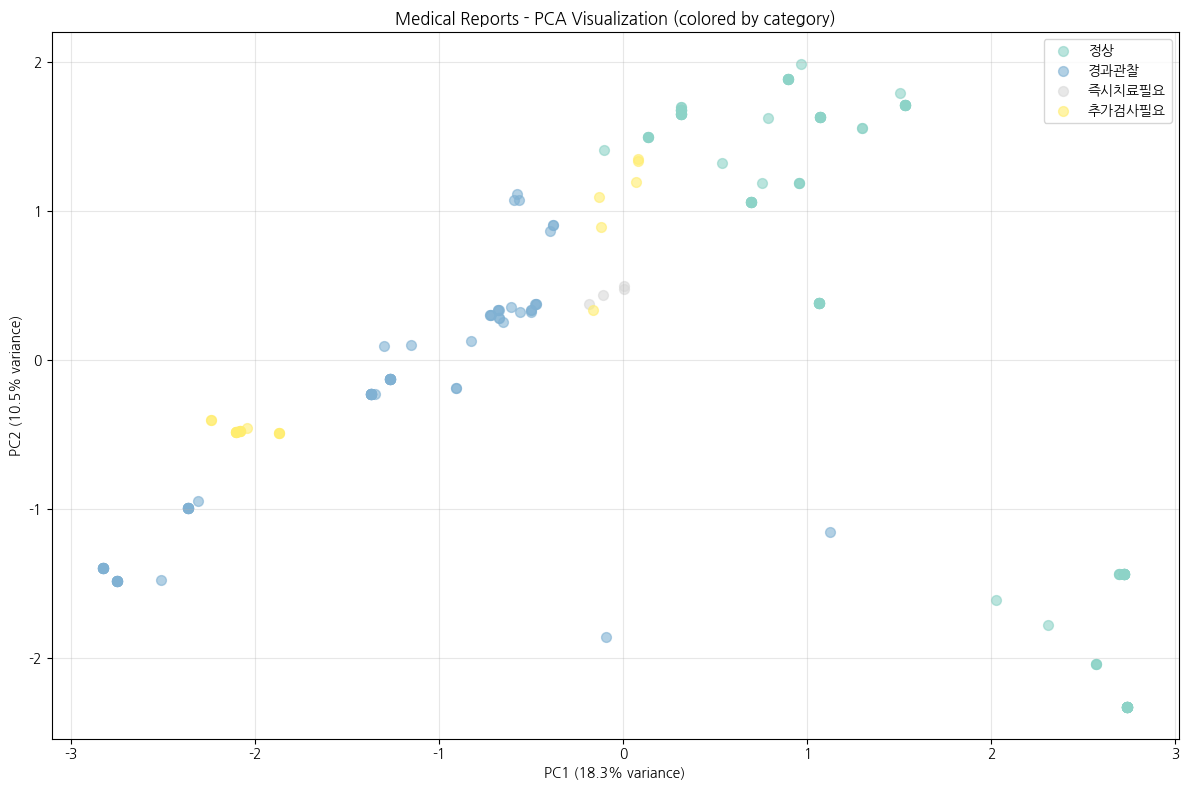

PCA 시각화 완료

PCA 정보:
  PC1 설명 분산: 18.3%
  PC2 설명 분산: 10.5%
  총 설명 분산: 28.9%


In [ ]:
if df is not None:
    visualize_with_pca(doc_term_matrix, df, color_by='category')

---

## 8. 시각화 - t-SNE

In [ ]:
def visualize_with_tsne(doc_term_matrix, df, color_by='category',
                        perplexity=30, figsize=(12, 8)):
    """
    t-SNE를 이용한 2D 시각화

    Parameters:
    -----------
    doc_term_matrix : np.ndarray
        문서-단어 행렬
    df : pd.DataFrame
        데이터프레임
    color_by : str
        색상 구분 기준 컬럼
    perplexity : int
        t-SNE perplexity 파라미터
    """
    print("t-SNE 계산 중... (시간이 소요될 수 있습니다)")

    # t-SNE 수행
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    coords = tsne.fit_transform(doc_term_matrix)

    # 카테고리별 색상 지정
    categories = df[color_by].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
    category_to_color = {cat: colors[i] for i, cat in enumerate(categories)}

    # 시각화
    plt.figure(figsize=figsize)

    for category in categories:
        mask = df[color_by] == category
        plt.scatter(
            coords[mask, 0],
            coords[mask, 1],
            c=[category_to_color[category]],
            label=category,
            alpha=0.6,
            s=50
        )

    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('Medical Reports - t-SNE Visualization (colored by %s)' % color_by)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("=" * 80)
    print("t-SNE 시각화 완료")
    print("=" * 80)

### t-SNE 시각화 실행

t-SNE 계산 중... (시간이 소요될 수 있습니다)


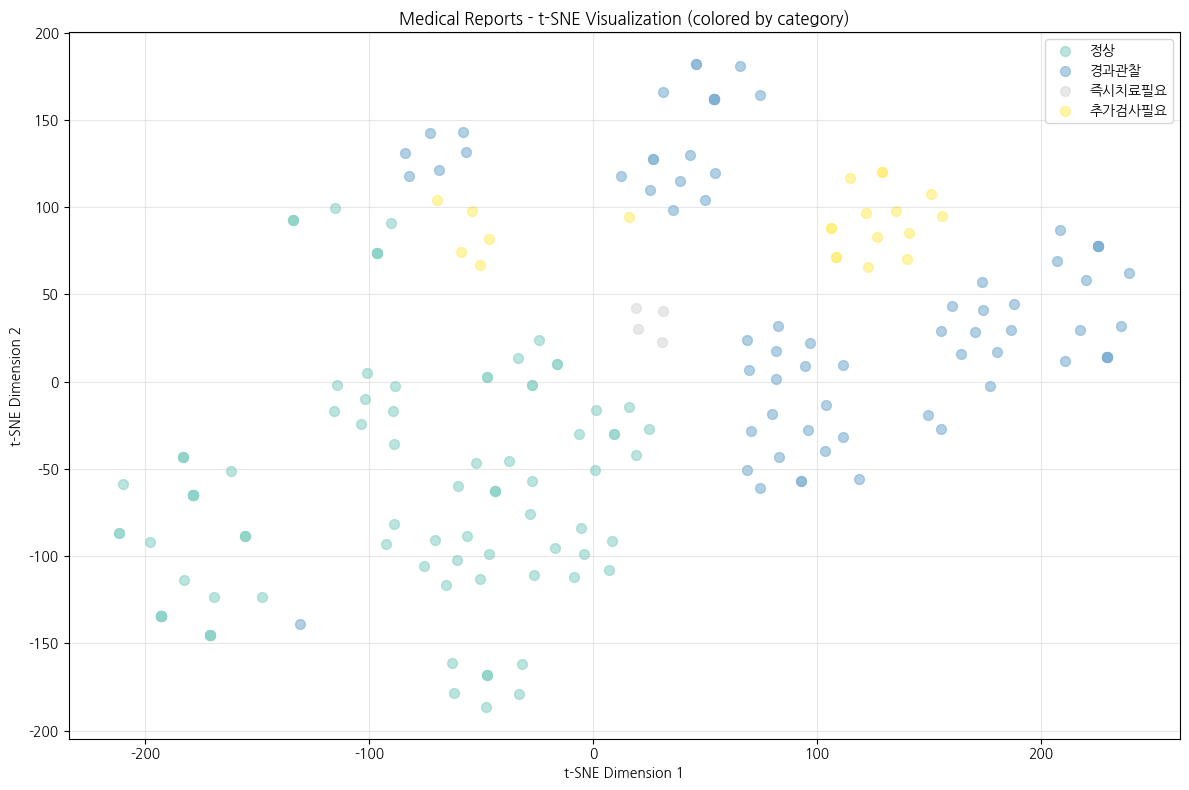

t-SNE 시각화 완료


In [ ]:
if df is not None:
    visualize_with_tsne(doc_term_matrix, df, color_by='category', perplexity=30)

---

## 9. 검사 유형별 시각화


검사 유형별 PCA 시각화:


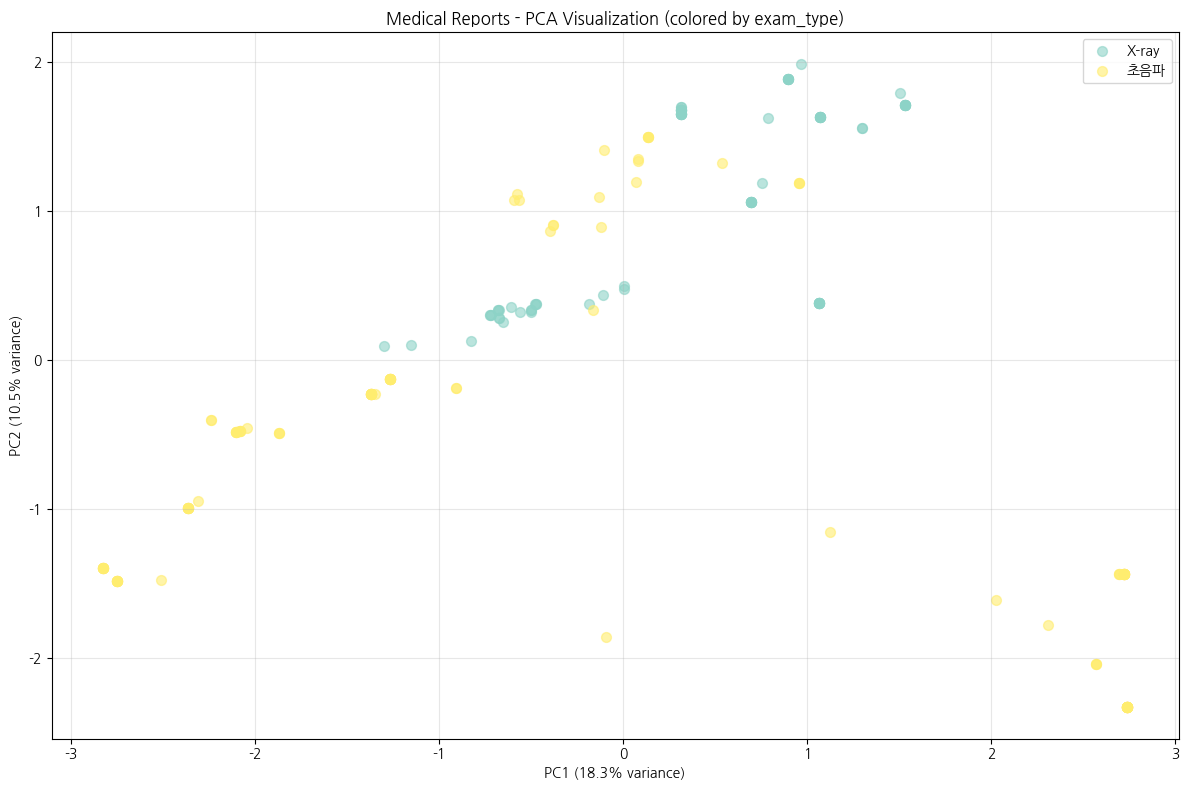

PCA 시각화 완료

PCA 정보:
  PC1 설명 분산: 18.3%
  PC2 설명 분산: 10.5%
  총 설명 분산: 28.9%

검사 유형별 t-SNE 시각화:
t-SNE 계산 중... (시간이 소요될 수 있습니다)


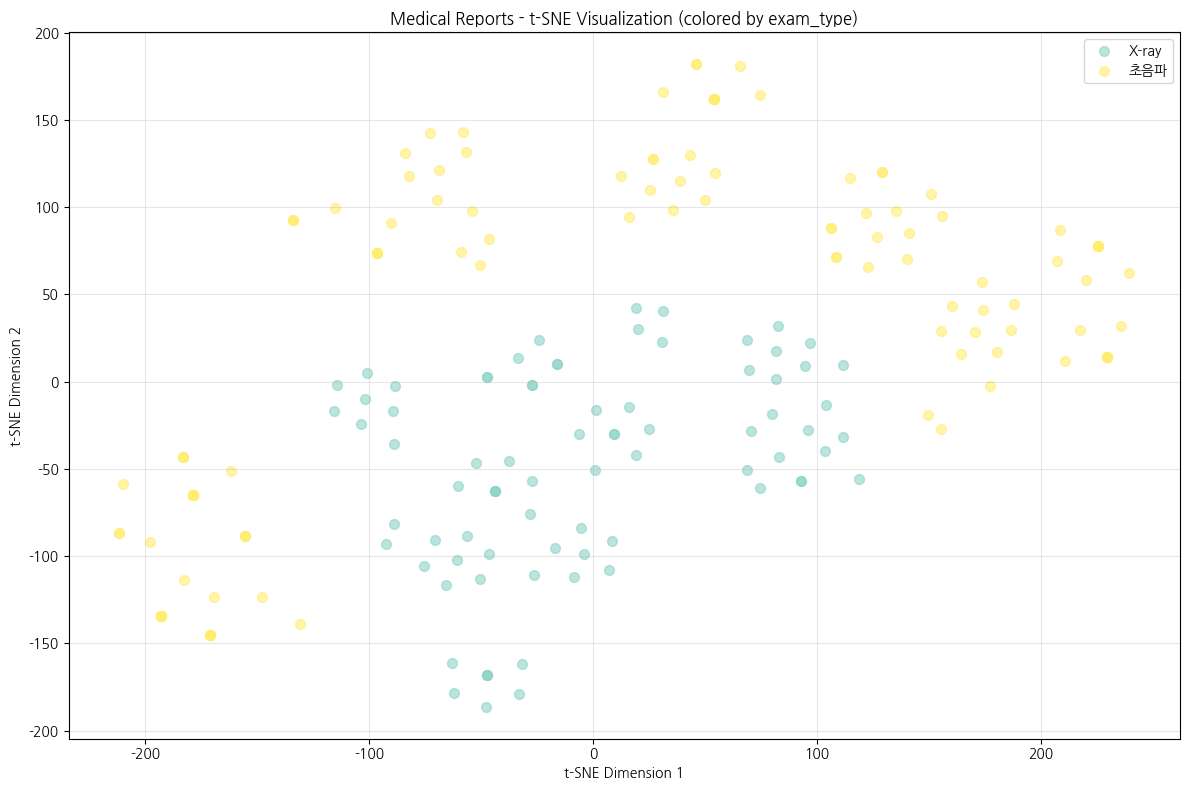

t-SNE 시각화 완료


In [ ]:
if df is not None and 'exam_type' in df.columns:
    print("\n검사 유형별 PCA 시각화:")
    visualize_with_pca(doc_term_matrix, df, color_by='exam_type')

    print("\n검사 유형별 t-SNE 시각화:")
    visualize_with_tsne(doc_term_matrix, df, color_by='exam_type', perplexity=30)

---

## 10. 카테고리별 주요 단어 분석

In [ ]:
def analyze_category_keywords(df, vocabulary, doc_term_matrix,
                              category_column='category', top_k=10):
    """
    카테고리별 주요 단어 추출

    Parameters:
    -----------
    df : pd.DataFrame
        데이터프레임
    vocabulary : list of str
        vocabulary 리스트
    doc_term_matrix : np.ndarray
        문서-단어 행렬
    category_column : str
        카테고리 컬럼명
    top_k : int
        추출할 단어 수
    """
    print("=" * 80)
    print("카테고리별 주요 단어 분석")
    print("=" * 80)

    categories = df[category_column].unique()

    for category in categories:
        print("\n[%s]" % category)

        # 해당 카테고리의 문서들
        mask = df[category_column] == category
        category_docs = doc_term_matrix[mask]

        # 단어 빈도 합계
        word_freq = category_docs.sum(axis=0)

        # 상위 k개 단어
        top_indices = np.argsort(word_freq)[::-1][:top_k]

        print("  주요 단어 (빈도순):")
        for rank, idx in enumerate(top_indices, 1):
            print("    %d. %s (%d회)" % (rank, vocabulary[idx], word_freq[idx]))

### 카테고리별 키워드 분석 실행

In [ ]:
if df is not None:
    analyze_category_keywords(df, vocabulary, doc_term_matrix,
                             category_column='category', top_k=10)

카테고리별 주요 단어 분석

[정상]
  주요 단어 (빈도순):
    1. 양측 (90회)
    2. 없습니다. (71회)
    3. 정상 (65회)
    4. 심장 (41회)
    5. 양측 폐야는 (40회)
    6. 폐야는 (40회)
    7. 특이 (37회)
    8. 정상 범위입니다. (37회)
    9. 범위입니다. (37회)
    10. 특이 없습니다. (36회)

[경과관찰]
  주요 단어 (빈도순):
    1. 정상입니다. (55회)
    2. 기타 (54회)
    3. 약 (49회)
    4. 관찰됩니다. (49회)
    5. 장기는 정상입니다. (46회)
    6. 기타 장기는 (46회)
    7. 장기는 (46회)
    8. 크기의 (32회)
    9. numcm (29회)
    10. 약 numcm (29회)

[즉시치료필요]
  주요 단어 (빈도순):
    1. 폐렴 (4회)
    2. 보입니다. (4회)
    3. 경화 소견이 (4회)
    4. 경화 (4회)
    5. 소견이 (4회)
    6. 폐렴 초기로 (2회)
    7. 있습니다. (2회)
    8. 초기로 (2회)
    9. 우하엽에 (2회)
    10. 보입니다. 폐렴 (2회)

[추가검사필요]
  주요 단어 (빈도순):
    1. 정상입니다. (17회)
    2. 관찰됩니다. (17회)
    3. num 크기의 (15회)
    4. 장기는 (15회)
    5. 장기는 정상입니다. (15회)
    6. num (15회)
    7. 크기의 (15회)
    8. 기타 장기는 (15회)
    9. 결석이 (15회)
    10. 기타 (15회)


---

## 11. Summary

이 노트북에서는 의료 판독문 데이터를 전처리하고, N-gram + BOW 방식을 사용하여 문서 벡터화했습니다. 이 벡터를 기반으로 문서 유사도를 분석하고, PCA와 t-SNE를 활용하여 고차원 데이터를 2D로 시각화했습니다. 마지막으로 카테고리별 주요 단어를 분석하여 각 카테고리의 특징적인 키워드를 파악했습니다.